# Text-to-image generation with Z-Image-Turbo and OpenVINO

Z-Image-Turbo is Alibaba's production-ready, open-source 6B-parameter image generation model from the Z-Image family.

<img width="1321" height="799" alt="image" src="https://github.com/user-attachments/assets/070c0b45-ad11-45eb-8d88-e077819cce48" />

**Highlights**

- Photorealistic quality + strong bilingual (Chinese & English) text rendering
- Excellent instruction-following and in-context editing (supports bounding boxes, object-level control)
- Uses Single-Stream Diffusion Transformer (S3-DiT): text and image tokens processed in one unified stream
- Prompt Enhancer (PE) + Decoupled DMD/DMDR distillation for high-quality 1–8 step generation

More details about model can be found in [paper post](https://arxiv.org/pdf/2511.22699) and [model card](https://huggingface.co/Tongyi-MAI/Z-Image-Turbo).

In this tutorial we consider how to convert and optimize Z-Image-Turbo model using OpenVINO.

>**Note**: Some demonstrated models can require at least 32GB RAM for conversion and running.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Select model](#Select-model)
- [Convert model with OpenVINO](#Convert-model-with-OpenVINO)
  - [Convert model using Optimum Intel](#Convert-model-using-Optimum-Intel)
  - [Compress model weights](#Compress-model-weights)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).


<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/z-image-turbo/z-image-turbo.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import platform
import requests
from pathlib import Path

if not Path("cmd_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py")
    open("cmd_helper.py", "w").write(r.text)

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/flux.1-kontext/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

if not Path("pip_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/pip_helper.py",
    )
    open("pip_helper.py", "w").write(r.text)

from pip_helper import pip_install

%pip uninstall -q -y diffusers optimum-intel

pip_install(
    "-q",
    "gradio>=4.19,<6",
    "torch==2.8",
    "torchvision==0.23.0",
    "nncf>=2.15.0",
    "--extra-index-url",
    "https://download.pytorch.org/whl/cpu",
)
pip_install("-q", "git+https://github.com/huggingface/diffusers")
pip_install("-q", "git+https://github.com/openvino-dev-samples/optimum-intel.git@zimage")
pip_install("-qU", "openvino>=2025.4")

if platform.system() == "Darwin":
    pip_install("numpy<2.0.0")


# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("z-image-turbo.ipynb")

## Select model
[back to top ⬆️](#Table-of-contents:)

In [1]:
import ipywidgets as widgets

model_id = "Tongyi-MAI/Z-Image-Turbo"

## Convert model with OpenVINO
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 

Z-Image-Turbo is based on scalable Single-Stream DiT (S3-DiT) architecture. In this setup, text, visual semantic tokens, and image VAE tokens are concatenated at the sequence level to serve as a unified input stream, maximizing parameter efficiency compared to dual-stream approaches. The S3-DiT consists of single-stream FFN blocks and single-stream attention blocks. It processes inputs from different modalities through lightweight modality-specific processors, then concatenates them into a unified input sequence. This modality agnostic architecture maximizes cross-modal parameter reuse to ensure parameter efficiency, while providing flexible compatibility for varying input configurations in both Z-Image and Z-Image-Edit.

<img width="1058" height="643" alt="image" src="https://github.com/user-attachments/assets/68fd9895-f7c1-48fc-b96d-79ed6a06959d" />

The pipeline of Optimum-intel consists of 3 important parts:

* Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for encoding and decoding image.
  
### Convert model using Optimum Intel
[back to top ⬆️](#Table-of-contents:)

For convenience, we will use OpenVINO integration with HuggingFace Optimum. 🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Among other use cases, Optimum Intel provides a simple interface to optimize your Transformers and Diffusers models, convert them to the OpenVINO Intermediate Representation (IR) format and run inference using OpenVINO Runtime. `optimum-cli` provides command line interface for model conversion and optimization. 

General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager). Additionally, you can specify weights compression using `--weight-format` argument with one of following options: `fp32`, `fp16`, `int8` and `int4`. Fro int8 and int4 [nncf](https://github.com/openvinotoolkit/nncf) will be used for  weight compression. More details about model export provided in [Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/openvino/export#export-your-model).

### Compress model weights
[back to top ⬆️](#Table-of-contents:)

For reducing model memory consumption we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality. We will use [NNCF](https://github.com/openvinotoolkit/nncf) integration to `optimum-cli` tool for weight compression.

### Use optimized models provided on HuggingFace Hub
[back to top ⬆️](#Table-of-contents:)

For quick start, OpenVINO provides [collection](https://huggingface.co/collections/OpenVINO/image-generation-67697d9952fb1eee4a252aa8) of optimized models that are ready to use with OpenVINO GenAI. You can download them using following command:

```bash
huggingface-cli download <model_id> --local-dir <output_dir>
```


In [2]:
to_compress = widgets.Checkbox(
    value=True,
    description="Weight compression",
    disabled=False,
)

visible_widgets = [to_compress]

options = widgets.VBox(visible_widgets)

options

In [3]:
from pathlib import Path

model_base_dir = Path(model_id.split("/")[-1])
additional_args = {"task": "text-to-image"}

if to_compress.value:
    model_dir = model_base_dir / "INT4"
    additional_args.update({"weight-format": "int4", "group-size": "64", "ratio": "1.0"})
else:
    model_dir = model_base_dir / "FP16"
    additional_args.update({"weight-format": "fp16"})

In [4]:
from cmd_helper import optimum_cli

if not model_dir.exists():
    optimum_cli(model_id, model_dir, additional_args=additional_args)

## Run Optimum-intel model inference
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [5]:
from notebook_utils import device_widget

device = device_widget(default="CPU", exclude=["NPU"])
device

Dropdown(description='Device:', options=('CPU', 'GPU', 'AUTO'), value='CPU')

In [6]:
import ipywidgets as widgets

model_available = (model_base_dir / "INT4").is_dir()
use_quantized_models = widgets.Checkbox(
    value=model_available,
    description="Use compressed models",
    disabled=not model_available,
)

use_quantized_models

Checkbox(value=True, description='Use compressed models')

OpenVINO integration with Optimum Intel provides ready-to-use API for model inference that can be used for smooth integration with transformers-based solutions. For loading Flux.1 Kontext model, we will use `OVFluxKontextPipeline` class that have compatible interface with Diffusers `FluxKontextPipeline` implementation. For loading a model, `from_pretrained` method should be used. It accepts path to the model directory or model_id from HuggingFace hub (if model is not converted to OpenVINO format, conversion will be triggered automatically). Additionally, we can provide an inference device, quantization config (if model has not been quantized yet) and device-specific OpenVINO Runtime configuration. More details about model inference with Optimum Intel can be found in [documentation](https://huggingface.co/docs/optimum/intel/openvino/inference).

In [7]:
from optimum.intel import OVZImagePipeline
import torch

model_dir = model_base_dir / "INT4" if use_quantized_models.value else model_base_dir / "FP16"

ov_pipe = OVZImagePipeline.from_pretrained(model_dir, device=device.value)

Skipping import of cpp extensions due to incompatible torch version 2.8.0+cpu for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
/home2/ethan/intel/openvino_notebooks/openvino_venv/lib/python3.10/site-packages/librosa/util/files.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
Multiple distributions found for package optimum. Picked distribution: optimum-onnx
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
/home2/ethan/intel/openvino_notebooks/openvino_venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings

Now, you can define a text prompt and other pipeline settings for image generation and run inference pipeline.

  0%|          | 0/9 [00:00<?, ?it/s]

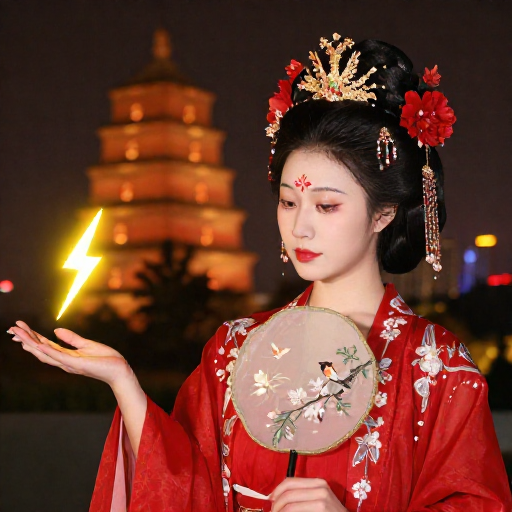

In [18]:
prompt = "Young Chinese woman in red Hanfu, intricate embroidery. Impeccable makeup, red floral forehead pattern. Elaborate high bun, golden phoenix headdress, red flowers, beads. Holds round folding fan with lady, trees, bird. Neon lightning-bolt lamp (⚡️), bright yellow glow, above extended left palm. Soft-lit outdoor night background, silhouetted tiered pagoda (西安大雁塔), blurred colorful distant lights."

image = ov_pipe(
    prompt=prompt,
    height=512,
    width=512,
    num_inference_steps=9,  # This actually results in 8 DiT forwards
    guidance_scale=0.0,  # Guidance should be 0 for the Turbo models
    generator=torch.Generator("cpu").manual_seed(42),
).images[0]

image

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_pipe)

# if you are launching remotely, specify server_name and server_port
#  demo.launch(server_name='your server name', server_port='server port in int')
# if you have any issue to launch on your platform, you can pass share=True to launch method:
# demo.launch(share=True)
# it creates a publicly shareable link for the interface. Read more in the docs: https://gradio.app/docs/
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)